In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd

# plot style
sns.set_style('whitegrid')
sns.set_style({'font.family': 'Times New Roman'})

sns.set_context("paper", font_scale=1)

In [2]:
total = pd.read_csv("total.csv", index_col=0)

In [3]:
journals = total[total['type']=="JOURNALS"]
print("All journals' success rate: "+ str(journals.success.sum()*1./len(journals)))

All journals' success rate: 0.42036431574030825


In [4]:
from helpers import fix_name, fix_name2

journals.name = journals.name.apply(fix_name)
journals.name = journals.name.apply(fix_name2)

In [12]:
policy = pd.read_csv("data/journal-policy-survey.txt", sep ='\t')

In [14]:
policy.name = policy.name.apply(fix_name2)
policy.head(3)

,name,link,type,level
0,American Journal of Political\nScience (AJPS),https://ajps.org/ajps-verification-policy/,verification,5
1,British Journal of\nPolitical Science,https://www.cambridge.org/core/services/aop-fi...,required,3
2,American Political\nScience Review,https://www.apsanet.org/APSR-Submission-Guidel...,required,3


In [15]:
journal_policy = pd.merge(journals,policy,on='name')

In [16]:
len(journal_policy)

1968

In [17]:
agg_total = pd.read_csv("agg_total.csv", index_col=0)

In [18]:
ag_journals = agg_total[agg_total['type']=="JOURNALS"]
ag_journals = ag_journals.drop(ag_journals[ag_journals.success.isnull()].index)

ag_journals.name = ag_journals.name.apply(fix_name)
ag_journals.name = ag_journals.name.apply(fix_name2)

In [19]:
print("Aggregated all journals' success rate: "+ str(ag_journals.success.sum()/len(ag_journals)))

Aggregated all journals' success rate: 0.4729381443298969


In [20]:
ag_journal_policy = pd.merge(ag_journals,policy,on='name')

In [21]:
barWidth = 0.8

def get_stats(df):
    res = df.groupby(
        ['success', 'name']).size().reset_index().pivot(columns='success', index='name', values=0)

    res.fillna(0.0, inplace=True)
    res['total'] = [i+j for i,j in zip(res[1],res[0])]

    res['s'] = [i / j * 100 for i,j in zip(res[1], res['total'])]

    res = res.sort_values(by=['total'], ascending=False)
    return res

import matplotlib.patches as patches
from helpers import *

def make_plot(plt, temp, pos):
    pal = sns.color_palette("nipy_spectral")
    colors = {"no policy": pal[4], "encouraged": pal[3], "required": pal[2], "reviewed": pal[1], "verification": pal[0]} 
    
    names = list(temp.name)
    r= range(0,len(temp['s']))
    plt.bar(r, temp['s'], color=temp.type.map(colors), alpha=1., edgecolor='black', width=barWidth)

    global labels, handles
    labels = list(colors.keys())
    if pos == 2:
        plt.set_xticks(r)
        plt.set_xticklabels(names, rotation=90) #, fontsize=14)
    else:
        plt.set_xticks([])
        handles = [patches.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        
    plt.set_ylim(0,77)

    temp['names'] = temp.index
    temp = temp.reset_index(drop=True)

    temp.s = temp.s.round(1)
    temp.total = temp.total.astype(int)

    autolabel(plt.patches, plt)
    autolabel_count_boxed(plt.patches, plt, temp)

    plt.yaxis.grid(True) # Hide the horizontal gridlines
    plt.xaxis.grid(False) # Show the vertical gridlines

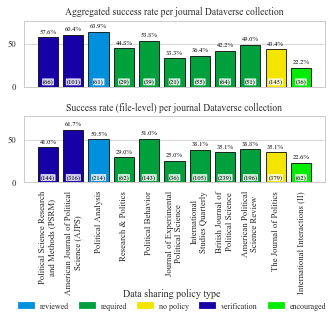

In [23]:
fig, axs = plt.subplots(2,1, figsize=(4.78,4.3)) #, gridspec_kw={"height_ratios": (.45, .55)})

j2 = get_stats(ag_journals).head(11)
j2 = pd.merge(j2.reset_index(),policy,on='name').sort_values(by=['type','name'], ascending=False)
make_plot(axs[0], j2, pos=1)
axs[0].set_title("Aggregated success rate per journal Dataverse collection") #, size=20)

j1 = get_stats(journals)
j1 = pd.merge(j1.reset_index(),policy,on='name').sort_values(by=['type','name'], ascending=False)
j1 = j1.drop(j1[~j1.name.isin(j2.name)].index)
make_plot(axs[1], j1, pos=2)
axs[1].set_title("Success rate (file-level) per journal Dataverse collection") #, size=20)

legend = fig.legend(
            handles, labels, frameon=False, #facecolor='white', 
            #edgecolor='gray', 
            fontsize=8,
            title="Data sharing policy type", ncol=5,
            bbox_to_anchor=(0.03, -.025, .94, .14),
            mode="expand", #borderaxespad=0.,
            loc = 'center',
            )

fig.tight_layout()

plt.savefig("publisher_temp1.pdf", bbox_inches = "tight", dpi=100)